# CycleGAN

Tikhonov Denis
User ID: 187533895

Источники информации:

1) За основу была взята оригинальная [статья первоисточник](https://arxiv.org/abs/1703.10593) (очень хочется в это верить)

2) https://github.com/wiseodd/generative-models

3) https://habr.com/ru/company/ods/blog/322514/

4) https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278

# Из лошади в зебру с помощью CycleGAN
Здесь на основе [этой статьи](https://habr.com/ru/company/ods/blog/340154/) будет повторена уже решенная задача по изменению лошадей и зебр на изображениях

## Архитектура из статьи

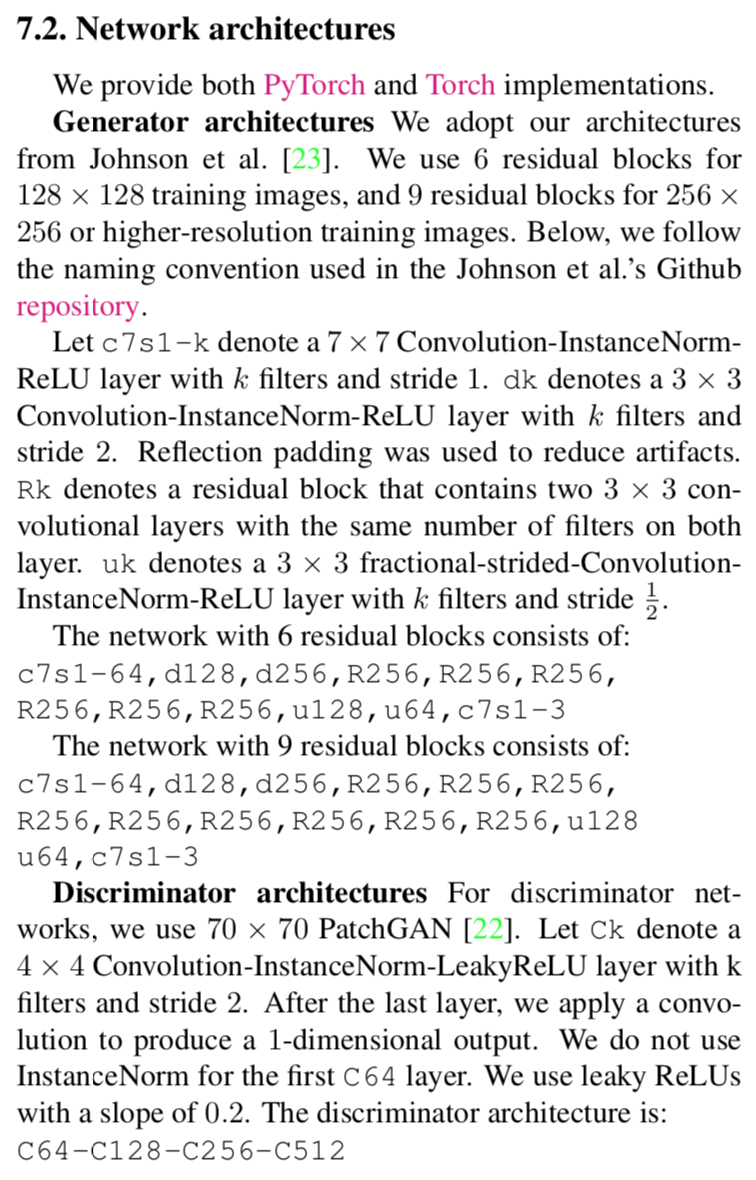

# Загрузка изображений

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!unzip -q /content/gdrive/MyDrive/horse2zebra.zip

In [3]:
from pathlib import Path

train_horse = Path('horse2zebra/trainA')
train_zebra = Path('horse2zebra/trainB')
test_horse = Path('horse2zebra/testA')
test_zebra = Path('horse2zebra/testB')

train_A_files = sorted(list(train_horse.rglob('**/*.jpg')))[:800]
train_B_files = sorted(list(train_zebra.rglob('*.jpg')))[:800]
test_A_files = sorted(list(test_horse.rglob('*.jpg')))
test_B_files = sorted(list(test_zebra.rglob('*.jpg')))

print(len(train_A_files))
print(len(train_B_files))
print(len(test_A_files))
print(len(test_B_files))

800
800
120
140


# Использование изображений

In [4]:
import pickle
import numpy as np
from skimage import io
import itertools

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

class Images_Dataset(Dataset):

      def __init__(self, files_A, files_B, rescale_size = 128):
        super().__init__()

        self.files_A = sorted(files_A)

        self.files_B = sorted(files_B)

        self.rescale_size = rescale_size

      def __getitem__(self, index):

        transform = transforms.Compose([
            transforms.Resize(self.rescale_size),                            
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
        ])

        A_i = Image.open(self.files_A[index % len(self.files_A)]).convert('RGB')# % - помогает при разном количесве примеров в A и B
        A_i = transform(A_i)
        
        B_i = Image.open(self.files_B[index % len(self.files_B)]).convert('RGB')# % - помогает при разном количесве примеров в A и B
        B_i = transform(B_i)

        return {"A": A_i, "B": B_i}

      def __len__(self):
        return max(len(self.files_A), len(self.files_B))



def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])#np.array([0.485, 0.456, 0.406])
    std = np.array([0.5, 0.5, 0.5])#np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

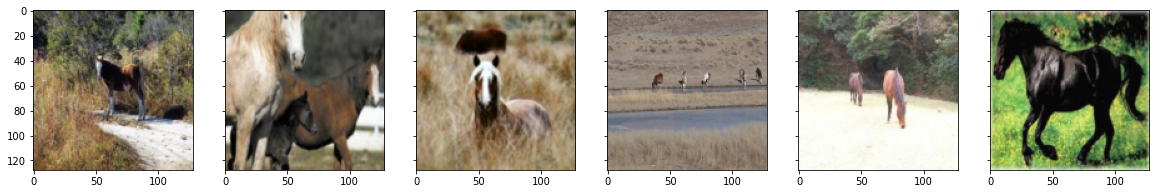

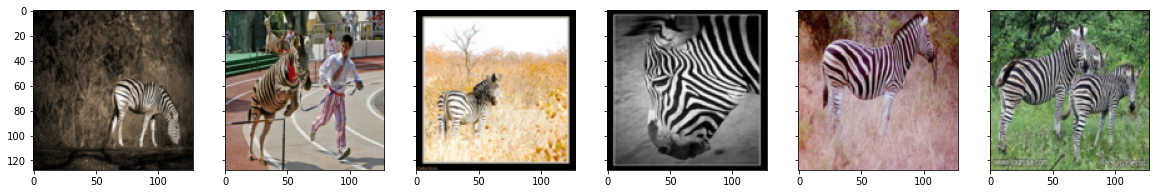

In [5]:
train_dataset = Images_Dataset(train_A_files,train_B_files)

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(20, 10), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    random_pic = train_dataset[random_characters]
    imshow(random_pic['A'].data.cpu(),plt_ax=fig_x)

fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(20, 5), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    random_pic = train_dataset[random_characters]
    imshow(random_pic['B'].data.cpu(),plt_ax=fig_x)

# Построение модели
Для тренировочного примера повторим простую архитектуру для обработки изображений 128 на 128 

(Выбираем простую для того, чтобы хватало памяти на колабе)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)
        
class ResBlock(nn.Module):
    def __init__(self, n_input):
        super(ResBlock, self).__init__()

        self.resblock = nn.Sequential(
            nn.ReflectionPad2d(1),
            
            nn.Conv2d(n_input, n_input, 3),
            nn.InstanceNorm2d(n_input),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(1),

            nn.Conv2d(n_input, n_input, 3),
            nn.InstanceNorm2d(n_input)
            )

    def forward(self, x):
        return x + self.resblock(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            #c7s1-64
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            #d128
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            #d256
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            #9_res_blocks
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            #u128
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            #u64
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            #??????
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7, stride=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            #C64_without_instance_norm
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            #C128
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            #C256
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            #C512
            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            #C1
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        x = self.main(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

# Обучение модели

In [7]:
import torch
import random
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda:0")

    

CUDA is available!  Training on GPU ...


In [8]:
RESCALE_SIZE = 128
n_epochs = 20
batch_size = 20

In [9]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

####################################################################################
Gen_A2B = Generator().to(device)
Gen_B2A = Generator().to(device)
Disc_A  = Discriminator().to(device)
Disc_B  = Discriminator().to(device)

####################################################################################
loss_GAN      = torch.nn.MSELoss().to(device)
loss_cycle    = torch.nn.L1Loss().to(device)
loss_identity = torch.nn.L1Loss().to(device)

####################################################################################
optim_G   = torch.optim.Adam(itertools.chain(Gen_A2B.parameters(), Gen_B2A.parameters()),
                             lr=0.0002,
                             betas=(0.5, 0.999))

optim_D_A = torch.optim.Adam(Disc_A.parameters(),
                             lr=0.0002,
                             betas=(0.5, 0.999))

optim_D_B = torch.optim.Adam(Disc_B.parameters(),
                             lr=0.0002,
                             betas=(0.5, 0.999))

####################################################################################
losses_G = []
losses_D_A = []
losses_D_B = []

losses_GAN      = []
losses_cycle    = []
losses_identity = []

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

####################################################################################

In [36]:
log_template = " \nEpoch {ep:03d}  sum_loss_G: {sum_loss_G:0.4f} loss_D_A_full {loss_D_A_full:0.4f} loss_D_B_full {loss_D_B_full:0.4f}\
                 loss_identity_A {loss_identity_A:0.4f} loss_identity_B {loss_identity_B:0.4f}"

with tqdm(desc="epoch", total=n_epochs) as pbar_outer:
  for epoch in range(n_epochs):

    for i, batch in enumerate(dataloader):
      real_image_A = batch["A"].to(device)
      real_image_B = batch["B"].to(device)

      # real data label is 1, fake data label is 0.
      real_label = torch.full((batch_size, 1),
                              1,
                              device=device,
                              dtype=torch.float32)

      fake_label = torch.full((batch_size, 1),
                              0,
                              device=device,
                              dtype=torch.float32)

      ###### Generators ##############################
      optim_G.zero_grad()

      loss_identity_B = 5.0*loss_identity(Gen_A2B(real_image_B),
                                          real_image_B)

      loss_identity_A = 5.0*loss_identity(Gen_B2A(real_image_A),
                                          real_image_A)
      losses_identity.append((loss_identity_A + loss_identity_B)/2.0)
      

      fake_image_B = Gen_A2B(real_image_A)
      loss_GAN_A2B = loss_GAN(Disc_B(fake_image_B),
                              real_label)

      fake_image_A = Gen_B2A(real_image_B)
      loss_GAN_B2A = loss_GAN(Disc_A(fake_image_A),
                              real_label)
      losses_GAN.append((loss_GAN_B2A+loss_GAN_A2B)/2.0)

      cycle_A = Gen_B2A(fake_image_B)
      loss_cycle_ABA = 10.0*loss_cycle(cycle_A,
                                        real_image_A)

      cycle_B = Gen_A2B(fake_image_A)
      loss_cycle_BAB = 10.0*loss_cycle(cycle_B,
                                        real_image_B)
      losses_cycle.append((loss_cycle_BAB+loss_cycle_ABA)/2.0)

      sum_loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
      losses_G.append(sum_loss_G)
      sum_loss_G.backward()

      optim_G.step()
      ###########################################################

      ###### Discriminator A ####################################
      optim_D_A.zero_grad()

      loss_D_A_real = loss_GAN(Disc_A(real_image_A),
                              real_label)

      fake_A = fake_A_buffer.push_and_pop(fake_image_A)
      loss_D_A_fake = loss_GAN(Disc_A(fake_A.detach()),
                              fake_label)

      loss_D_A_full = (loss_D_A_real + loss_D_A_fake)/2.0
      losses_D_A.append(loss_D_A_full)
      loss_D_A_full.backward()

      optim_D_A.step()
      ###################################

      ###### Discriminator B ####################################
      optim_D_B.zero_grad()

      loss_D_B_real = loss_GAN(Disc_B(real_image_B),
                              real_label)

      fake_B = fake_B_buffer.push_and_pop(fake_image_B)
      loss_D_B_fake = loss_GAN(Disc_B(fake_B.detach()),
                              fake_label)

      loss_D_B_full = (loss_D_B_real + loss_D_B_fake)/2.0
      losses_D_B.append(loss_D_B_full)
      loss_D_B_full.backward()

      optim_D_B.step()
      ###################################



    tqdm.write(log_template.format(ep=epoch+1,
                                   sum_loss_G=sum_loss_G,
                                  loss_D_A_full=loss_D_A_full,
                                  loss_D_B_full=loss_D_B_full,
                                  loss_identity_A=loss_identity_A,
                                  loss_identity_B=loss_identity_B))
    pbar_outer.update(1)
###################################

epoch:   5%|▌         | 1/20 [01:45<33:15, 105.04s/it]

 
Epoch 001  sum_loss_G: 6.3455 loss_D_A_full 0.1529 loss_D_B_full 0.0855                 loss_identity_A 0.7574 loss_identity_B 0.8520


epoch:  10%|█         | 2/20 [03:30<31:33, 105.20s/it]

 
Epoch 002  sum_loss_G: 6.0963 loss_D_A_full 0.1861 loss_D_B_full 0.1357                 loss_identity_A 0.7134 loss_identity_B 0.6835


epoch:  15%|█▌        | 3/20 [05:16<29:50, 105.35s/it]

 
Epoch 003  sum_loss_G: 5.5175 loss_D_A_full 0.1297 loss_D_B_full 0.0951                 loss_identity_A 0.7276 loss_identity_B 0.7767


epoch:  20%|██        | 4/20 [07:02<28:08, 105.51s/it]

 
Epoch 004  sum_loss_G: 5.2034 loss_D_A_full 0.1402 loss_D_B_full 0.1642                 loss_identity_A 0.6824 loss_identity_B 0.8490


epoch:  25%|██▌       | 5/20 [08:48<26:24, 105.66s/it]

 
Epoch 005  sum_loss_G: 5.4872 loss_D_A_full 0.0971 loss_D_B_full 0.1101                 loss_identity_A 0.7037 loss_identity_B 0.7445


epoch:  30%|███       | 6/20 [10:34<24:40, 105.74s/it]

 
Epoch 006  sum_loss_G: 6.0471 loss_D_A_full 0.0903 loss_D_B_full 0.0606                 loss_identity_A 0.7744 loss_identity_B 0.7431


epoch:  35%|███▌      | 7/20 [12:19<22:54, 105.75s/it]

 
Epoch 007  sum_loss_G: 5.4247 loss_D_A_full 0.0954 loss_D_B_full 0.0609                 loss_identity_A 0.6726 loss_identity_B 0.7903


epoch:  40%|████      | 8/20 [14:05<21:08, 105.67s/it]

 
Epoch 008  sum_loss_G: 5.8671 loss_D_A_full 0.0888 loss_D_B_full 0.1203                 loss_identity_A 0.7018 loss_identity_B 0.8023


epoch:  45%|████▌     | 9/20 [15:51<19:22, 105.65s/it]

 
Epoch 009  sum_loss_G: 5.1595 loss_D_A_full 0.1225 loss_D_B_full 0.1193                 loss_identity_A 0.5849 loss_identity_B 0.6791


epoch:  50%|█████     | 10/20 [17:36<17:36, 105.66s/it]

 
Epoch 010  sum_loss_G: 5.0268 loss_D_A_full 0.1056 loss_D_B_full 0.1039                 loss_identity_A 0.6282 loss_identity_B 0.7121


epoch:  55%|█████▌    | 11/20 [19:22<15:50, 105.64s/it]

 
Epoch 011  sum_loss_G: 5.3947 loss_D_A_full 0.0821 loss_D_B_full 0.1099                 loss_identity_A 0.7301 loss_identity_B 0.6400


epoch:  60%|██████    | 12/20 [21:07<14:05, 105.64s/it]

 
Epoch 012  sum_loss_G: 5.2480 loss_D_A_full 0.0891 loss_D_B_full 0.1043                 loss_identity_A 0.7136 loss_identity_B 0.6874


epoch:  65%|██████▌   | 13/20 [22:53<12:19, 105.66s/it]

 
Epoch 013  sum_loss_G: 5.5302 loss_D_A_full 0.1105 loss_D_B_full 0.1165                 loss_identity_A 0.5664 loss_identity_B 0.6482


epoch:  70%|███████   | 14/20 [24:39<10:34, 105.74s/it]

 
Epoch 014  sum_loss_G: 5.9234 loss_D_A_full 0.0753 loss_D_B_full 0.0745                 loss_identity_A 0.5853 loss_identity_B 0.7092


epoch:  75%|███████▌  | 15/20 [26:25<08:49, 105.83s/it]

 
Epoch 015  sum_loss_G: 5.4686 loss_D_A_full 0.1414 loss_D_B_full 0.1174                 loss_identity_A 0.5948 loss_identity_B 0.6683


epoch:  80%|████████  | 16/20 [28:11<07:03, 105.80s/it]

 
Epoch 016  sum_loss_G: 5.6693 loss_D_A_full 0.1250 loss_D_B_full 0.2122                 loss_identity_A 0.7127 loss_identity_B 0.7806


epoch:  85%|████████▌ | 17/20 [29:57<05:17, 105.79s/it]

 
Epoch 017  sum_loss_G: 5.7483 loss_D_A_full 0.1083 loss_D_B_full 0.0768                 loss_identity_A 0.6593 loss_identity_B 0.6686


epoch:  90%|█████████ | 18/20 [31:42<03:31, 105.72s/it]

 
Epoch 018  sum_loss_G: 5.0533 loss_D_A_full 0.1675 loss_D_B_full 0.1053                 loss_identity_A 0.5331 loss_identity_B 0.7615


epoch:  95%|█████████▌| 19/20 [33:28<01:45, 105.66s/it]

 
Epoch 019  sum_loss_G: 4.9464 loss_D_A_full 0.1071 loss_D_B_full 0.0662                 loss_identity_A 0.6303 loss_identity_B 0.6143


epoch: 100%|██████████| 20/20 [35:13<00:00, 105.68s/it]

 
Epoch 020  sum_loss_G: 4.8393 loss_D_A_full 0.0934 loss_D_B_full 0.0672                 loss_identity_A 0.5346 loss_identity_B 0.6183


In [14]:
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

# Результаты

In [53]:
test_dataset = Images_Dataset(test_A_files[5:20],test_B_files[5:20])

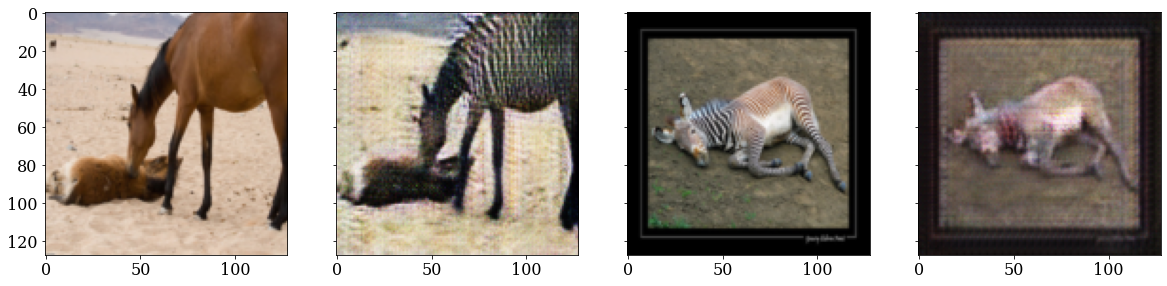

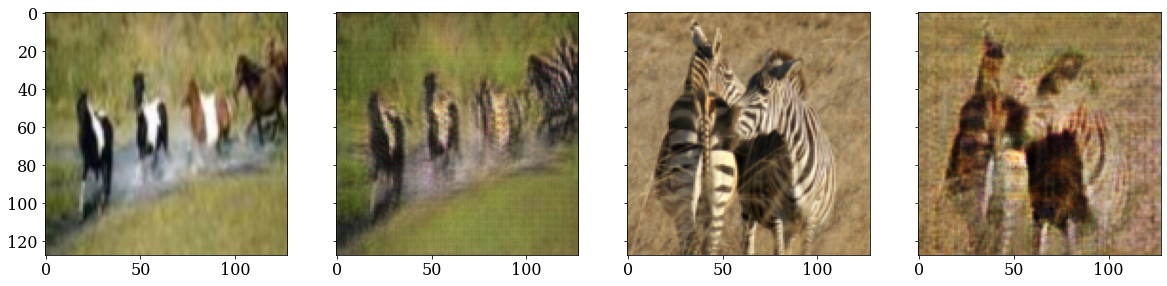

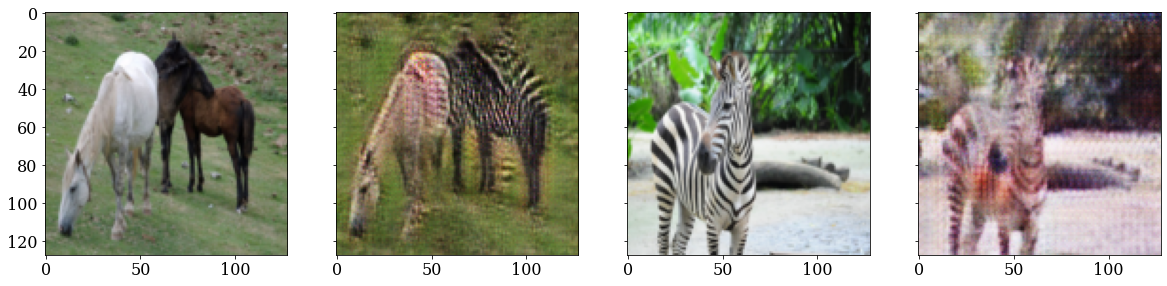

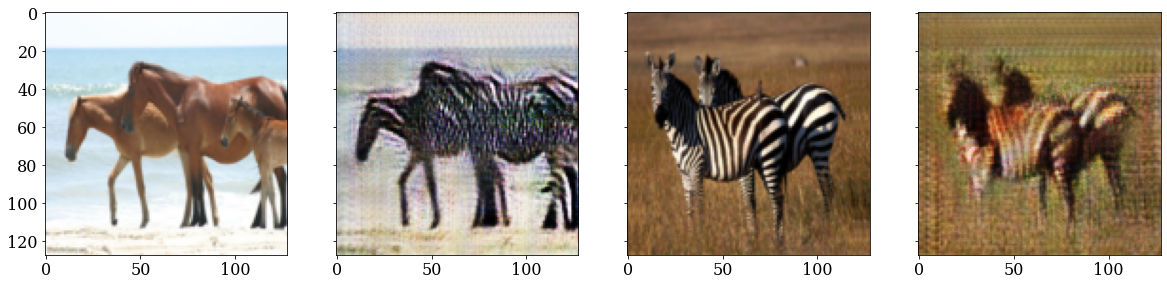

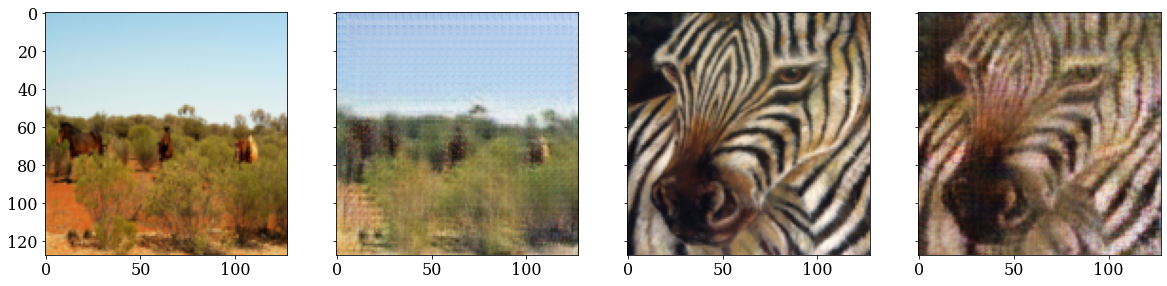

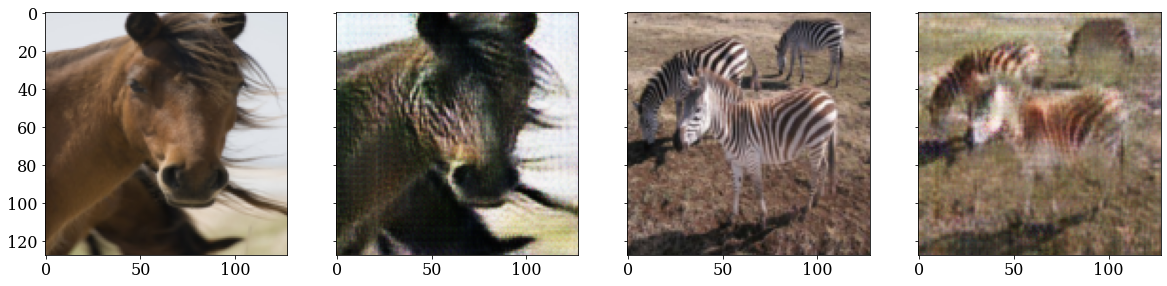

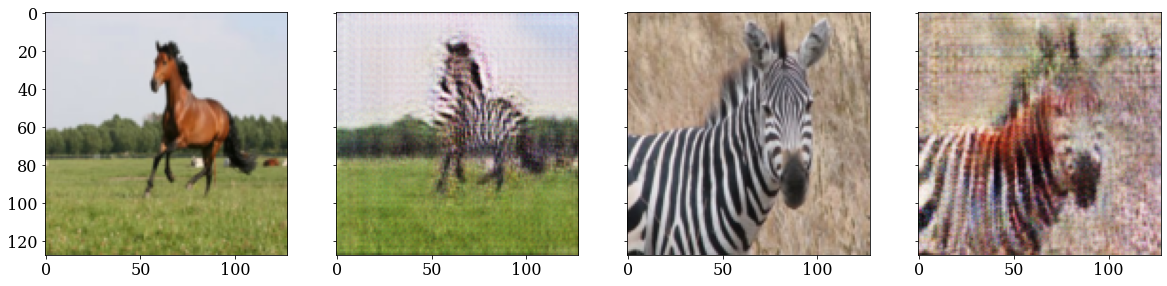

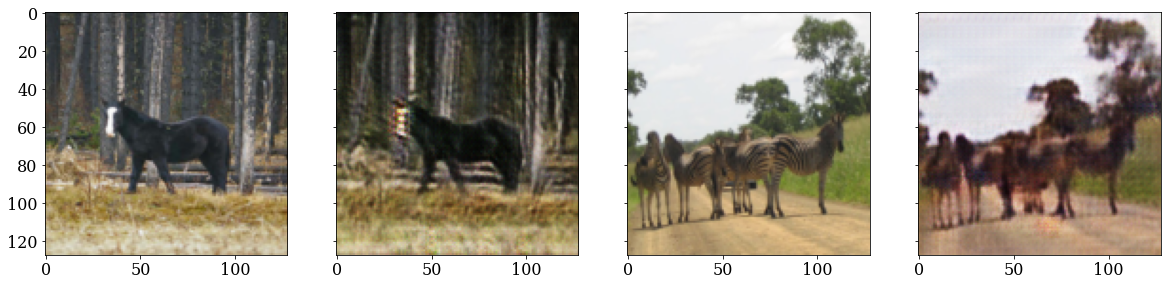

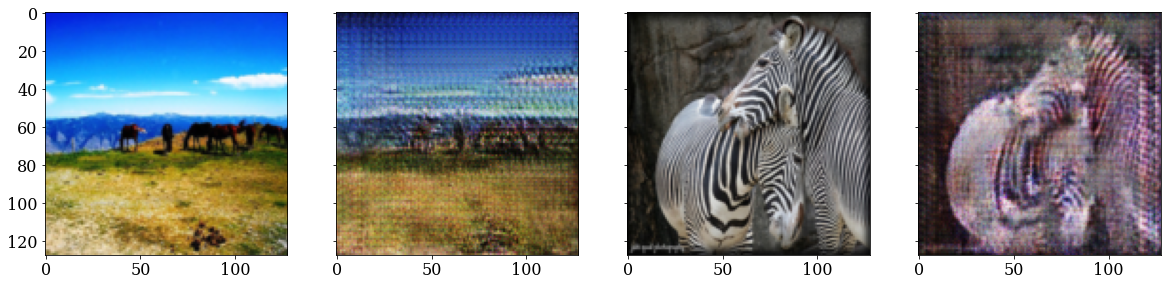

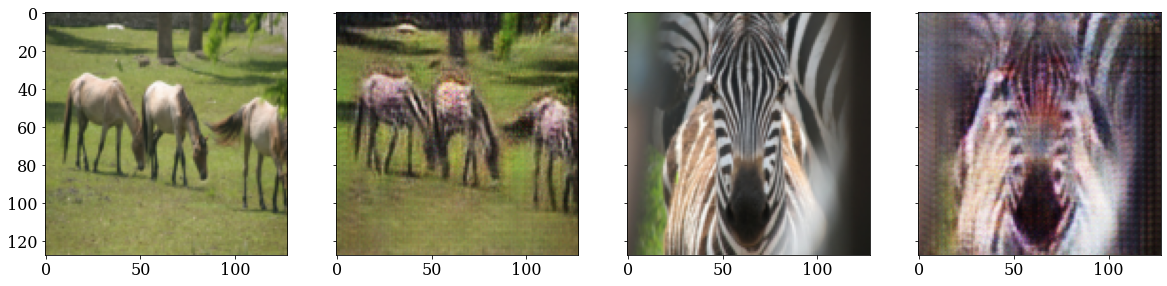

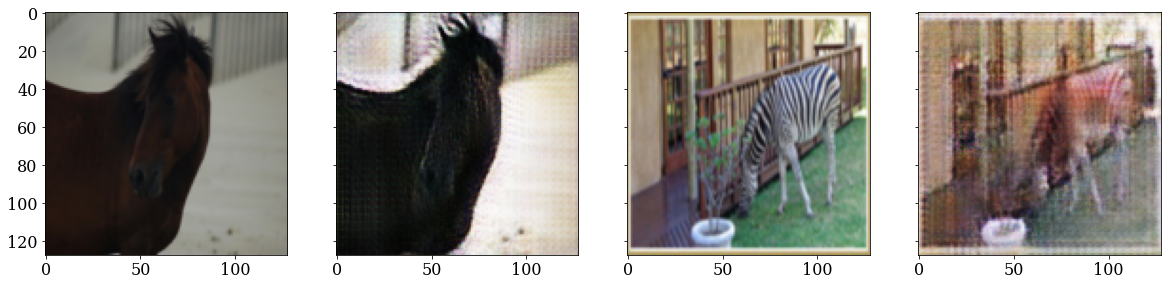

In [54]:
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
fake_images_A = []
fake_images_B = []
with torch.no_grad():

  Gen_A2B.eval()
  Gen_B2A.eval()

  for i, data in enumerate(dataloader_test):
      # get batch size data
      real_images_A = data["A"].to(device)
      real_images_B = data["B"].to(device)

      # Generate output
      fake_image_A = 1 * (Gen_B2A(real_images_B).data)
      fake_image_B = 1 * (Gen_A2B(real_images_A).data)

      fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(20, 5), sharey=True, sharex=True)
      fig_x = ax.flatten()
      imshow(fake_image_B.data.cpu()[0],plt_ax=fig_x[1])
      imshow(real_images_A.cpu()[0],plt_ax=fig_x[0])
      imshow(fake_image_A.data.cpu()[0],plt_ax=fig_x[3])
      imshow(real_images_B.cpu()[0],plt_ax=fig_x[2])
    


Так как в коде не было предусмотретна загурска-выгрузка параметров сети, то для финальной отправки сеть была обучена на 40 эпохах (что мало в сравнении с 200 в статьей).

Однако даже для такого маленького количева эпох видно, что нейросеть справляется со своей задачей (но не на всех изображениях).